<a href="https://colab.research.google.com/github/avisekh007/face_verification_one_shot/blob/main/face_verification3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning (EC-412) Assignment 3


---


Name: Avisekh Ghosh
<br>
Roll No.: 2k17/EE/62
<br>
Github: https://github.com/avisekh007/face_verification_one_shot


---




## Face Verification
Face recognition identifies persons on face images or video frames. A face recognition system extracts features from an input face image and compares them to the features of labeled faces in a database. Comparison is based on a feature similarity metric and the label of the most similar database entry is used to label the input image. If the similarity value is below a certain threshold the input image is labeled as unknown. Comparing two face images to determine if they show the same person is known as face verification.

This notebook uses a pre-trained deep convolutional neural network (CNN) to extract features from input images. Keras is used for implementing the CNN, Dlib and OpenCV for aligning faces on input images. Face recognition performance is evaluated on a small subset of the LFW dataset can be replaces with custom dataset for experimenting. 

**Procedure for Face Verification:**

1.   Detect, transform, and crop faces on input images. This ensures that faces are aligned before feeding them into the CNN. This preprocessing step is very important for the performance of the neural network.
2.   Use the CNN to extract 128-dimensional representations, or embeddings, of faces from the aligned input images. In embedding space, Euclidean distance directly corresponds to a measure of face similarity.
3.  Compare input embedding vectors to labeled embedding vectors in a database. Here, a support vector machine (SVM) and a KNN classifier, trained on labeled embedding vectors, play the role of a database. Face recognition in this context means using these classifiers to predict the labels i.e. identities of new inputs.



## Environment setup
Download a local copy of [Dlib's](http://dlib.net/) face landmarks data file for running face alignment.

In [1]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

In [2]:
download_landmarks('landmarks.dat')

In [3]:
# Download model, weights and utilities
!wget https://raw.githubusercontent.com/avisekh007/face_verification_one_shot/main/model.py \
      https://raw.githubusercontent.com/avisekh007/face_verification_one_shot/main/utils.py \
      https://raw.githubusercontent.com/cmusatyalab/openface/master/openface/align_dlib.py \
      https://github.com/iwantooxxoox/Keras-OpenFace/raw/master/model/nn4.small2.v1.h5

--2021-05-07 14:42:24--  https://raw.githubusercontent.com/avisekh007/face_verification_one_shot/main/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12191 (12K) [text/plain]
Saving to: ‘model.py’

model.py            100%[===================>]  11.91K  --.-KB/s    in 0s      

2021-05-07 14:42:24 (41.4 MB/s) - ‘model.py’ saved [12191/12191]

--2021-05-07 14:42:24--  https://raw.githubusercontent.com/avisekh007/face_verification_one_shot/main/utils.py
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 6537 (6.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   6.38K  --.-KB/s    in 0s      

2021-05-07 14:42:24 (60.1 MB/s) - ‘utils.py’ saved [6537/

## CNN architecture and training
The CNN architecture used here is a variant of the inception architecture. More precisely, it is a variant of the NN4 architecture identified as nn4.small2 model in the [OpenFace](https://cmusatyalab.github.io/openface/) project. This notebook uses a Keras implementation of that model whose definition was taken from the [Keras-OpenFace](https://github.com/iwantooxxoox/Keras-OpenFace) project. In architecture, there is a fully connected layer with 128 hidden units followed by an L2 normalization layer on top of the convolutional base. These two top layers are referred to as the embedding layer from which the 128-dimensional embedding vectors can be obtained. The complete model is defined in [model.py](https://github.com/avisekh007/face_verification_one_shot/blob/main/model.py). A Keras version of the nn4.small2 model can be created with create_model().

In [4]:
from model import create_model
from utils import load_weights

In [5]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('nn4.small2.v1.h5')

Instead of actually training a model from scratch I used a pre-trained model as training from scratch is very expensive and requires huge datasets to achieve good generalization performance.

The [OpenFace](https://cmusatyalab.github.io/openface/) project provides [pre-trained models](https://cmusatyalab.github.io/openface/models-and-accuracies/#pre-trained-models) that were trained with the public face recognition datasets [FaceScrub](http://vintage.winklerbros.net/facescrub.html) and [CASIA-WebFace](http://arxiv.org/abs/1411.7923). The Keras-OpenFace project converted the weights of the pre-trained nn4.small2.v1 model to [CSV files](https://github.com/iwantooxxoox/Keras-OpenFace/tree/master/weights) which were then converted to a [binary format](https://github.com/iwantooxxoox/Keras-OpenFace/raw/master/model/nn4.small2.v1.h5) that can be loaded by Keras with load_weights:

In [6]:
# Download dataset
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2021-05-07 14:42:35--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  88.4MB/s    in 1.9s    

2021-05-07 14:42:37 (88.4 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [7]:
# Extract the dataset
!tar -xf  'lfw.tgz' -C './'

## Custom dataset
To demonstrate face recognition on a custom dataset, a small subset of the [LFW dataset](http://vis-www.cs.umass.edu/lfw/) is used. It consists of 100 face images of 10 identities. The metadata for each image (file and identity name) are loaded into memory for later processing.

In [8]:
# Create custom dataset from the downloaded dataset
%%shell

dirs=(
  David_Beckham
  Arnold_Schwarzenegger
  Jackie_Chan
  Jennifer_Lopez
  George_W_Bush
  Gerhard_Schroeder
  Michael_Jackson
  Bill_Gates
  Tony_Blair
  Vladimir_Putin
)

for dir in "${dirs[@]}"
do
	mkdir -p images/$dir
  cp lfw/$dir/"${dir}"_000* lfw/$dir/"${dir}"_0010* images/$dir
done

In [9]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

## Face alignment
The nn4.small2.v1 model was trained with aligned face images, therefore, the face images from the custom dataset must be aligned too. Here, I used [Dlib](http://dlib.net/) for face detection and [OpenCV](https://opencv.org/) for image transformation and cropping to produce aligned 96x96 RGB face images by using the [AlignDlib utility](https://raw.githubusercontent.com/cmusatyalab/openface/master/openface/align_dlib.py) from the OpenFace project.

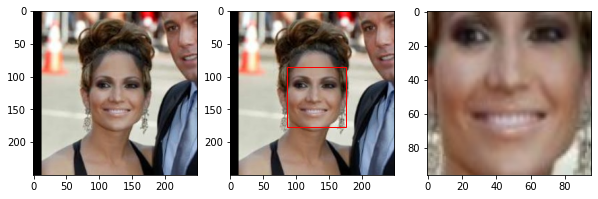

In [10]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align_dlib import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('landmarks.dat')

# Load an image of Jennifer Lopez
jc_orig = load_image(metadata[69].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

Here, the face detection, transformation and cropping as align_image function is implemented for later use.

In [11]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

## Embedding vectors
Embedding vectors is calculated by feeding the aligned and scaled images into the pre-trained network.



In [12]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

It can be verified that the squared L2 distance between its anchor-positive pair is smaller than the distance between its anchor-negative pair on the pre-trained model.

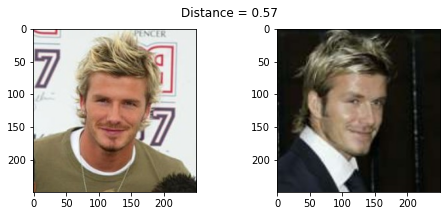

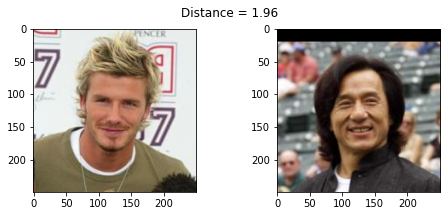

In [13]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(20, 21)
show_pair(20, 50)

As expected, the distance between the two images of David Beckham is smaller than the distance between an image of David Beckham and an image of Jackie Chan (0.57 < 1.96). But the distance threshold $\tau$ to be considered as best boundary for making a decision between same identity and different identity is unknown, and need to be calculated.

## Distance threshold

To find the optimal value for $\tau$, the face verification performance must be evaluated on a range of distance threshold values. At a given threshold, all possible embedding vector pairs are classified as either same identity or different identity and compared to the ground truth. Since we're dealing with skewed classes (much more negative pairs than positive pairs), I used the F1 score as evaluation metric instead of accuracy.

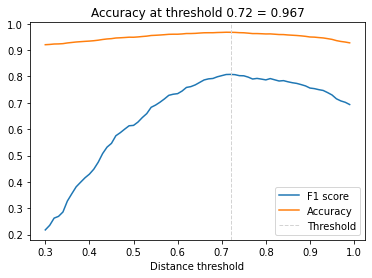

In [14]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(i + 1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

The face verification accuracy at $\tau$ = 0.72 is 96.7%.


The following two histograms show the distance distributions of positive and negative pairs and the location of the decision boundary. There is a clear separation of these distributions which explains the discriminative performance of the network.

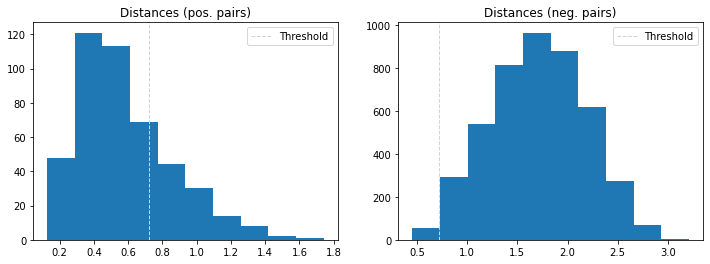

In [15]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

## Face recognition
Given an estimate of the distance threshold $\tau$, face recognition is now as simple as calculating the distances between an input embedding vector and all embedding vectors in a database. The input is assigned the label (i.e. identity) of the database entry with the smallest distance if it is less than $\tau$ or label unknown otherwise. It also supports one-shot learning, as adding only a single entry of a new identity might be sufficient to recognize new examples of that identity.

A more robust approach is to label the input using the top $k$ scoring entries in the database which is essentially KNN classification with a Euclidean distance metric. Alternatively, a linear support vector machine (SVM) can be trained with the database entries and used to classify i.e. identify new inputs.

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.94, SVM accuracy = 0.9


The KNN classifier achieves an accuracy of 94% on the test set, while the SVM classifier achieves 90%. Hence, I'm using the KNN classifier to illustrate face recognition on a single example.

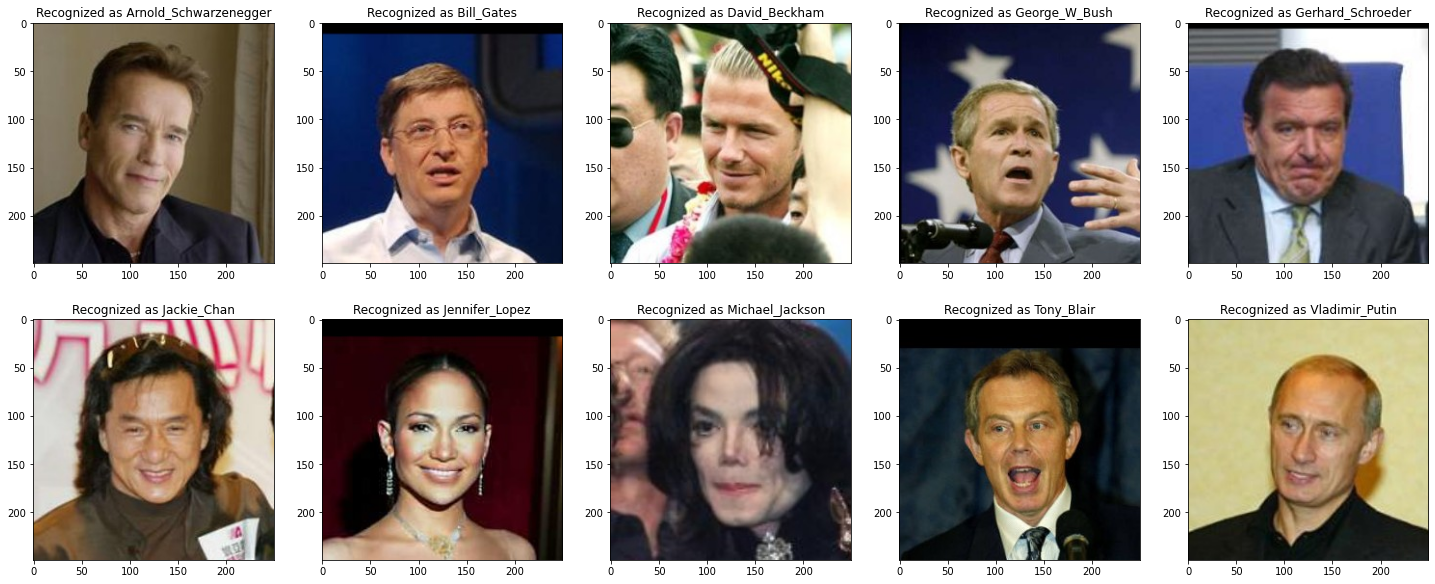

In [17]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

plt.figure(figsize=(25, 10))

for i in range (0,10):
  example_idx = i*5 + 1
  
  example_image = load_image(metadata[test_idx][example_idx].image_path())
  example_prediction = knn.predict([embedded[test_idx][example_idx]])
  example_identity = encoder.inverse_transform(example_prediction)[0]

  plt.subplot(2, 5, i+1)
  plt.imshow(example_image)
  plt.title(f'Recognized as {example_identity}');

## Dataset Visualization
To embed the dataset into 2D space for displaying identity clusters, [t-distributed Stochastic Neighbor Embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (t-SNE) is applied to the 128-dimensional embedding vectors. Except from a few outliers, identity clusters are well separated.

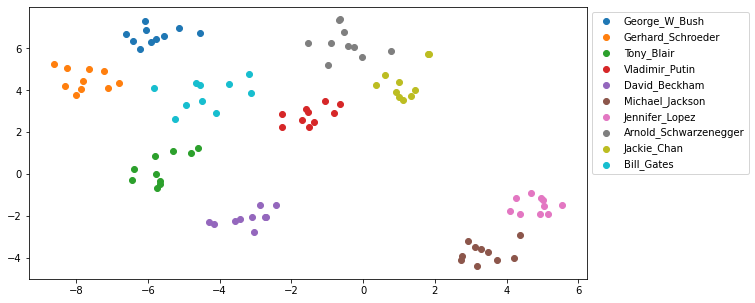

In [18]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

plt.figure(figsize=(10, 5))

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));